In [1]:
import datetime as dt
import pandas_datareader.data as pdr
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import coint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
tickers = ['SPY','AAPL','ADBE', 'EBAY','MSFT','QCOM', 'HPQ','JNPR','AMD','IBM'] # Enter all the tickers whose data you require
stock_cp = pd.DataFrame()
start_date = '2007/12/01' # Enter the Startdate in the form of datetime.date()
end_date = '2017/12/01' # Enter the End Date in the form of datetime.date()
drop = []
while len(tickers) != 0:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        temp = pdr.get_data_yahoo(tickers[i],start_date,end_date)
        temp.dropna(inplace = True)
        stock_cp[tickers[i]] = temp['Adj Close']
        drop.append(tickers[i])

In [4]:
stock_cp


,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
Date,,,,,,,,,,
2007-12-03,113.618752,22.079992,42.689999,13.549927,24.722271,29.028246,17.163849,26.714096,9.66,71.985878
2007-12-04,112.603134,22.197273,43.320000,13.541702,24.609631,28.592394,17.255726,26.749277,9.25,72.530060
2007-12-05,114.488113,22.899694,43.900002,13.714418,25.645983,29.430773,17.578997,27.532141,8.91,73.570740
2007-12-06,116.126823,23.449039,44.540001,13.887133,25.946377,29.459925,17.766153,27.488159,9.07,74.618256
2007-12-07,116.103828,23.986044,44.369999,13.870686,25.931356,29.248508,17.640244,27.180292,9.05,74.046928
...,...,...,...,...,...,...,...,...,...,...
2017-11-27,246.814728,167.818375,185.000000,35.164936,80.795258,61.709373,19.544840,25.339855,11.55,133.746140
2017-11-28,249.318634,166.835129,185.399994,34.686169,81.768227,62.449135,19.921940,26.089502,11.17,134.177338
2017-11-29,249.166916,163.374512,176.850006,33.591846,80.284676,60.750462,19.710394,27.403698,10.83,135.127762


In [5]:
scores, pvalues, pairs = find_cointegrated_pairs(stock_cp)

In [6]:
stock_cp.shape

(2519, 10)

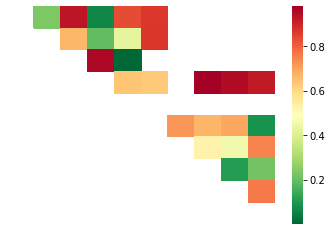

[('ADBE', 'MSFT')]


In [7]:
sns.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers,cmap="RdYlGn_r", mask=(pvalues >= 0.98))
plt.show()
print(pairs)

In [8]:
S1 = stock_cp['ADBE']
S2 = stock_cp['MSFT']

0.0013059677623059173


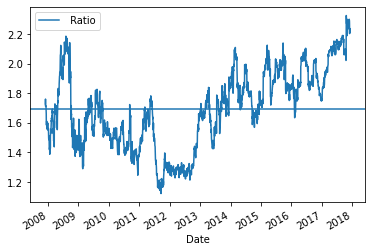

In [9]:
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

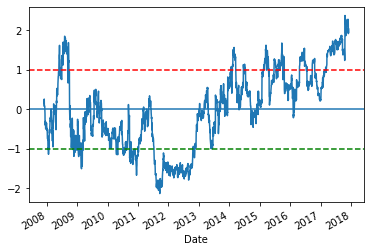

In [11]:
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red', ls='--')
plt.axhline(-1.0, color='green', ls='--')
plt.show()

In [12]:
len(ratios)*0.70

1763.3

In [13]:
train = ratios[:1764]
test = ratios[1764:]

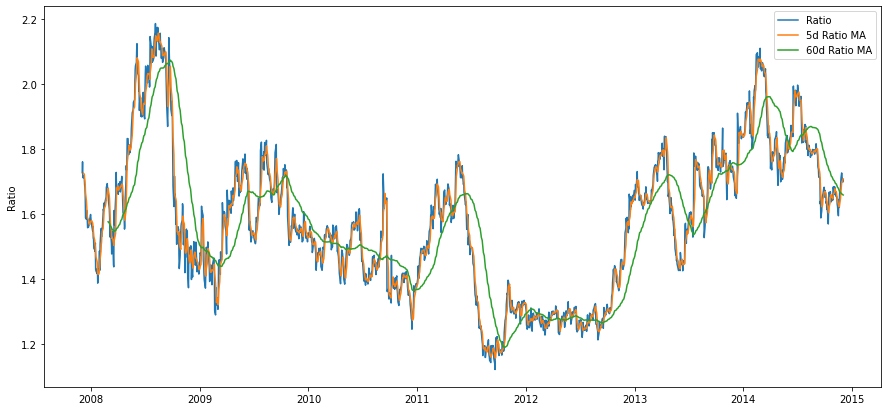

In [14]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()
ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()
std_60 = train.rolling(window=60,
                        center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

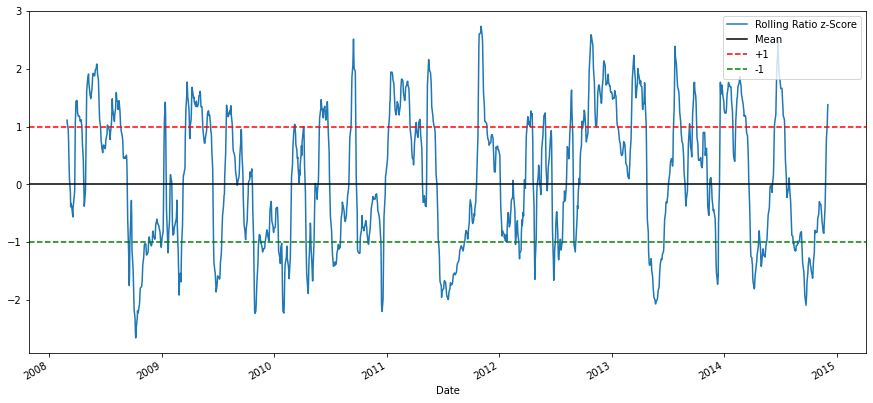

In [15]:
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

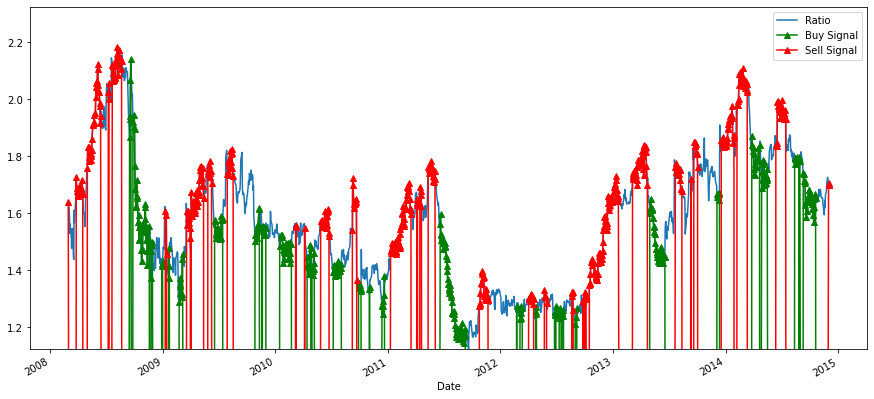

In [16]:
plt.figure(figsize=(15,7))
train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g' ,ls = None, marker='^')
sell[60:].plot(color='r',ls = None,  marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

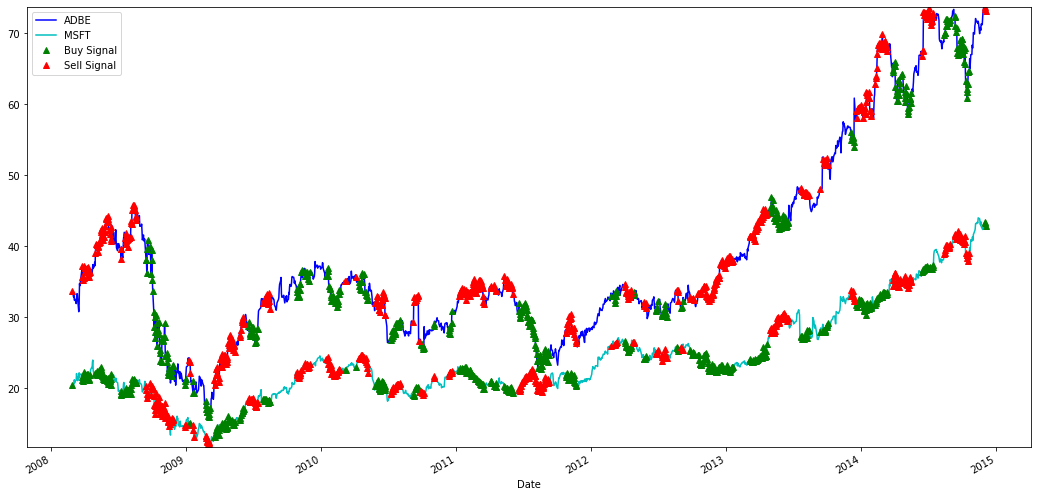

In [17]:
plt.figure(figsize=(18,9))
S1 = stock_cp['ADBE'].iloc[:1764]
S2 = stock_cp['MSFT'].iloc[:1764]
S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [18]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money
trade(stock_cp['ADBE'].iloc[:1764], stock_cp['MSFT'].iloc[:1764], 5, 60)

Selling Ratio 0.0 1.6783509271025812 -1 1.6783509271025812
Selling Ratio 0.0 1.640979801828134 -2 3.3193307289307152
Exit pos 5.528583079308007 1.5292719711740592 0 0
Exit pos 5.528583079308007 1.5621856278935449 0 0
Exit pos 5.528583079308007 1.549177538307607 0 0
Exit pos 5.528583079308007 1.5103905560357458 0 0
Exit pos 5.528583079308007 1.4768409934393298 0 0
Exit pos 5.528583079308007 1.5446549659521773 0 0
Exit pos 5.528583079308007 1.543340281497904 0 0
Exit pos 5.528583079308007 1.5470373299761924 0 0
Exit pos 5.528583079308007 1.4431468033774446 0 0
Exit pos 5.528583079308007 1.4373508949442175 0 0
Exit pos 5.528583079308007 1.610542823147112 0 0
Exit pos 5.528583079308007 1.5659977823215707 0 0
Exit pos 5.528583079308007 1.641564546611239 0 0
Exit pos 5.528583079308007 1.6632829982338755 0 0
Selling Ratio 5.528583079308007 1.7277143304116305 -1 1.7277143304116305
Selling Ratio 5.528583079308007 1.687249048190414 -2 3.4149633786020446
Selling Ratio 5.528583079308007 1.67907825

502.1702781492485

In [19]:
trade(stock_cp['ADBE'].iloc[1764:], stock_cp['MSFT'].iloc[1764:], 5, 60)

Selling Ratio 0.0 2.0297292655796095 -1 2.0297292655796095
Selling Ratio 0.0 2.0049742484513358 -2 4.034703514030945
Selling Ratio 0.0 2.0281881054496793 -3 6.062891619480625
Selling Ratio 0.0 2.0360058516494495 -4 8.098897471130075
Selling Ratio 0.0 2.0225860876282145 -5 10.121483558758289
Selling Ratio 0.0 2.0112430592636183 -6 12.132726618021907
Selling Ratio 0.0 2.0136383870936774 -7 14.146365005115584
Selling Ratio 0.0 2.0984492842552074 -8 16.24481428937079
Selling Ratio 0.0 2.08610565829362 -9 18.33091994766441
Selling Ratio 0.0 2.096070109706681 -10 20.42699005737109
Selling Ratio 0.0 2.1245031948338977 -11 22.55149325220499
Selling Ratio 0.0 2.0120284978572305 -12 24.56352175006222
Selling Ratio 0.0 2.0285936187411835 -13 26.5921153688034
Selling Ratio 0.0 2.0063873677337014 -14 28.598502736537103
Selling Ratio 0.0 1.9811164006578417 -15 30.579619137194946
Exit pos 43.05878856466893 1.9616406178292194 0 0
Exit pos 43.05878856466893 1.9692233824383714 0 0
Exit pos 43.0587885646

1063.2521986390866